In [58]:
import numpy as np
import pandas as pd
import os
import re

from survivors.tree import CRAID
from survivors.ensemble import BoostingCRAID
from survivors.experiments import grid as exp
from survivors import datasets as ds
from survivors.tree.stratified_model import LeafModel, LeafOnlySurviveModel, BaseFastSurviveModel, LeafOnlyHazardModel
from survivors import constants as cnt

from sksurv.linear_model import CoxPHSurvivalAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [166]:
def str_to_categ(df_col):
    uniq = df_col.unique()
    return df_col.map(dict(zip(uniq, range(len(uniq)))))

def load_clear_hdfail_dataset():
    df = pd.read_csv('./hdfail.csv')
    df = df.rename({"time": cnt.TIME_NAME, "event": cnt.CENS_NAME}, axis=1)
    df['fac_type'] = str_to_categ(df['fac_type'])
    sign = ['num_temp', 'fac_type']
    y = cnt.get_y(df[cnt.CENS_NAME], df[cnt.TIME_NAME])
    X = df.loc[:, sign]
    return X, y, sign, categ, []

def load_capacity_hdfail_dataset():
    df = pd.read_csv('./hdfail.csv')
    df = df.rename({"time": cnt.TIME_NAME, "event": cnt.CENS_NAME}, axis=1)
    df['fac_type'] = str_to_categ(df['fac_type'])
    categ = ['fac_type']
    sign = ['num_temp', 'fac_type', 'Capacity']
    y = cnt.get_y(df[cnt.CENS_NAME], df[cnt.TIME_NAME])
    X = df.loc[:, sign]
    return X, y, sign, categ, []

def load_all_hdfail_dataset():
    df = pd.read_csv('./hdfail.csv')
#     df = df[df["time"] < 4000].reset_index()
#     df["time"] = np.log(1 + df["time"])
    df = df.rename({"time": cnt.TIME_NAME, "event": cnt.CENS_NAME}, axis=1)
    categ = ['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer']
    sign = list(set(df.columns) - set(['fac_type', cnt.CENS_NAME, cnt.TIME_NAME, 'pid']))
    y = cnt.get_y(df[cnt.CENS_NAME], df[cnt.TIME_NAME])
    X = df.loc[:, sign]
    return X, y, sign, categ, []

In [167]:
DATASETS_LOAD = {
    "GBSG": ds.load_gbsg_dataset,
    "WUHAN": ds.load_wuhan_dataset,
    "PBC": ds.load_pbc_dataset,
    "HARD_1": load_clear_hdfail_dataset,
    "HARD_2": load_capacity_hdfail_dataset,
    "HARD_ALL": load_all_hdfail_dataset
}

In [168]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, CoxPHFitter

feats = ['Capacity', 'Form Factor', 'Height', 'Weight', "num_temp", "Buffer Size"]

class AFTBase(LeafModel):
    def __init__(self):
        super().__init__()
        
    def fit(self, X_node, need_features=[cnt.TIME_NAME, cnt.CENS_NAME]):
        X = X_node.fillna(0).replace(np.nan, 0)
        self.model.fit(X, cnt.TIME_NAME, cnt.CENS_NAME)
        print(self.model.print_summary())
        super().fit(X_node, need_features)

    def predict_survival_at_times(self, X=None, bins=None):
        if bins is None:
            bins = self.default_bins
        sf = self.model.predict_survival_function(X.fillna(0).replace(np.nan, 0), 
                                                  times=bins).to_numpy().T
        return sf

    def predict_hazard_at_times(self, X=None, bins=None):
        if bins is None:
            bins = self.default_bins
        hf = self.model.predict_cumulative_hazard(X.fillna(0).replace(np.nan, 0), 
                                                  times=bins).to_numpy().T
        return hf
    
class AFTLogLogisticAFTFitter(AFTBase):
    def fit(self, X_node, need_features=[cnt.TIME_NAME, cnt.CENS_NAME]):
        self.model = LogLogisticAFTFitter(penalizer = 0.5, l1_ratio = 0.5)
        super().fit(X_node, need_features)
    
class AFTLogNormalAFTFitter(AFTBase):
    def fit(self, X_node, need_features=[cnt.TIME_NAME, cnt.CENS_NAME]):
        self.model = LogNormalAFTFitter(penalizer = 0.5, l1_ratio = 0.5)
        super().fit(X_node, need_features)
        
class AFTWeibullAFTFitter(AFTBase):
    def fit(self, X_node, need_features=[cnt.TIME_NAME, cnt.CENS_NAME]):
        self.model = WeibullAFTFitter(penalizer = 0.5, l1_ratio = 0.5)
        super().fit(X_node, need_features)

In [169]:
GBSG_PARAMS = {
    "TREE": {
        "depth": [3, 5],
        "criterion": ["logrank", "peto", "tarone-ware", "wilcoxon"],
        "min_samples_leaf": [10, 100],
        'cut': [True, False],
        "signif": [0.3],
        "max_features": [1.0],
        "leaf_model": [LeafOnlySurviveModel, AFTLogLogisticAFTFitter, AFTWeibullAFTFitter]
    },
    "OnlyKM": {}
}

HARD_PARAMS = {
    "TREE_KM": {
        "depth": [10],
        "criterion": ["tarone-ware", "wilcoxon"],
        "min_samples_leaf": [100, 1000],
        'cut': [True, False],
        "signif": [0.01, 0.1],
        "max_features": [1.0],
        "leaf_model": [LeafOnlySurviveModel]
    },
    "TREE_AFT": {
        "depth": [5],
        "criterion": ["tarone-ware", "wilcoxon"],
        "min_samples_leaf": [1000, 3000, 5000],
        'cut': [True],
        "signif": [0.3],
        "max_features": [1.0],
        "leaf_model": [AFTLogLogisticAFTFitter]  # LeafOnlySurviveModel, 
    },
    "BOOST_param_grid" : {
        "aggreg_func": ['wei', 'mean'],
        "criterion": ["weights", "logrank", "peto", "tarone-ware", "wilcoxon"],
        "depth": [10],
        "ens_metric_name": ["ibs", "roc"],
        "max_features": ["sqrt"],  # 0.3
        "min_samples_leaf": [500], 
        "mode_wei": ['square', 'exp'],
        "n_estimators": [25],
        "size_sample": [0.5, 0.7],
        "all_weight": [False],
        "leaf_model": ["base_fast"],
        "weighted_tree": [True],
        "n_jobs": [2]
        # "woe" : [],
    },
    "OnlyKM": {}
}

PARAMS = {
    "GBSG": GBSG_PARAMS,
    "HARD_1": HARD_PARAMS,
    "HARD_2": HARD_PARAMS,
    "HARD_ALL": HARD_PARAMS
}

In [170]:
def run(dataset="GBSG"):
    lst_metrics = ["IBS", "IAUC"]
    if not (dataset in DATASETS_LOAD):
        print("DATASET %s IS NOT DEFINED" % (dataset))
    X, y, features, categ, sch_nan = DATASETS_LOAD[dataset]()
    experim = exp.Experiments(folds=5, dataset_name=dataset, except_stop="any")
    experim.set_metrics(lst_metrics)
    
    experim.add_method(LeafOnlySurviveModel, {})
    experim.add_method(AFTLogLogisticAFTFitter, {})
    experim.add_method(AFTWeibullAFTFitter, {})
    
    PARAMS[dataset]["TREE_KM"]["categ"] = [categ]
    experim.add_method(CRAID, PARAMS[dataset]["TREE_KM"])
    
#     PARAMS[dataset]["TREE_AFT"]["categ"] = [categ]
#     experim.add_method(CRAID, PARAMS[dataset]["TREE_AFT"])
#     PARAMS[dataset]["BOOST_param_grid"]["categ"] = [categ]
#     experim.add_method(BoostingCRAID, PARAMS[dataset]["BOOST_param_grid"])
    experim.run(X, y, verbose=1)
    df_full = experim.get_result()
    return df_full

df_result_hard = run(dataset="HARD_ALL")

<class 'survivors.tree.stratified_model.LeafOnlySurviveModel'> {}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.TIME_NAME] = y_train[cnt.TIME_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.CENS_NAME] = y_train[cnt.CENS_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivo

EXECUTION TIME OF LeafOnlySurviveModel: 41.82917237281799 {'IBS': 0.13054361280588225, 'IAUC': 0.4920540516911058}
<class '__main__.AFTLogLogisticAFTFitter'> {}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.LogLogisticAFTFitter: fitted with 41425 total observations, 39132 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 41425
number of events observed = 2293
           log-likelihood = -24571.17
         time fit was run = 2022-12-08 14:33:55 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                     
alpha_ Acoustic (Idle)                         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Acoustic (Max performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Acoustic (Min performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Average Rotational Latency              0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Average Seek Time                       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer Size                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer-Host Max. Rate                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Capacity                               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Depth                                   0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
       Disk Family                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Disk Interface                         -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
       Drive Ready Time (typical)             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Form Factor                             0.09       1.09       0.09            -0.09             0.26                 0.92                 1.30
       Full Stroke Seek Time                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Hard Disk Model                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Height                                 -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Manufacturer                           -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Disks                         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Heads                         0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Idle)                  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Power Required (Seek)                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Standby)               -0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
       Required Power For Spin

None


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.TIME_NAME] = y_train[cnt.TIME_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.CENS_NAME] = y_train[cnt.CENS_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: Fut

<lifelines.LogLogisticAFTFitter: fitted with 41425 total observations, 39132 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 41425
number of events observed = 2293
           log-likelihood = -23934.88
         time fit was run = 2022-12-08 14:34:13 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                     
alpha_ Acoustic (Idle)                        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Acoustic (Max performance and volume)  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Acoustic (Min performance and volume)  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Average Rotational Latency              0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
       Average Seek Time                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer Size                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer-Host Max. Rate                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Capacity                               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Depth                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Disk Family                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Disk Interface                         -0.00       1.00       0.02            -0.05             0.05                 0.96                 1.05
       Drive Ready Time (typical)             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Form Factor                             0.07       1.07       0.09            -0.10             0.24                 0.90                 1.27
       Full Stroke Seek Time                  -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Hard Disk Model                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Height                                  0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Manufacturer                           -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Disks                         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Heads                         0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Idle)                  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Power Required (Seek)                  -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Standby)               -0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
       Required Power For Spin

None


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.TIME_NAME] = y_train[cnt.TIME_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.CENS_NAME] = y_train[cnt.CENS_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: Fut

<lifelines.LogLogisticAFTFitter: fitted with 41426 total observations, 39132 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 41426
number of events observed = 2294
           log-likelihood = -23879.10
         time fit was run = 2022-12-08 14:34:31 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                     
alpha_ Acoustic (Idle)                        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Acoustic (Max performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Acoustic (Min performance and volume)  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Average Rotational Latency             -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Average Seek Time                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer Size                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer-Host Max. Rate                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Capacity                                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Depth                                   0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
       Disk Family                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Disk Interface                         -0.00       1.00       0.03            -0.06             0.06                 0.95                 1.06
       Drive Ready Time (typical)             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Form Factor                             0.10       1.11       0.09            -0.07             0.28                 0.93                 1.32
       Full Stroke Seek Time                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Hard Disk Model                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Height                                 -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Manufacturer                           -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Disks                        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Heads                        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Idle)                  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Power Required (Seek)                  -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Standby)                0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
       Required Power For Spin

None


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.TIME_NAME] = y_train[cnt.TIME_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.CENS_NAME] = y_train[cnt.CENS_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: Fut

<lifelines.LogLogisticAFTFitter: fitted with 41426 total observations, 39132 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 41426
number of events observed = 2294
           log-likelihood = -24137.99
         time fit was run = 2022-12-08 14:34:49 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                     
alpha_ Acoustic (Idle)                        -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
       Acoustic (Max performance and volume)  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Acoustic (Min performance and volume)  -0.00       1.00       0.01            -0.02             0.01                 0.99                 1.02
       Average Rotational Latency             -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Average Seek Time                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer Size                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer-Host Max. Rate                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Capacity                               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Depth                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Disk Family                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Disk Interface                         -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
       Drive Ready Time (typical)              0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Form Factor                             0.02       1.02       0.10            -0.17             0.22                 0.84                 1.24
       Full Stroke Seek Time                  -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Hard Disk Model                         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Height                                  0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Manufacturer                            0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Disks                        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Heads                         0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Idle)                   0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
       Power Required (Seek)                  -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Standby)               -0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
       Required Power For Spin

None


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.TIME_NAME] = y_train[cnt.TIME_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.CENS_NAME] = y_train[cnt.CENS_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: Fut

<lifelines.LogLogisticAFTFitter: fitted with 41426 total observations, 39132 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 41426
number of events observed = 2294
           log-likelihood = -24232.81
         time fit was run = 2022-12-08 14:35:06 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                     
alpha_ Acoustic (Idle)                        -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
       Acoustic (Max performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Acoustic (Min performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Average Rotational Latency              0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Average Seek Time                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer Size                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer-Host Max. Rate                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Capacity                               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Depth                                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Disk Family                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Disk Interface                          0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
       Drive Ready Time (typical)              0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Form Factor                             0.00       1.00       0.19            -0.36             0.36                 0.70                 1.44
       Full Stroke Seek Time                  -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
       Hard Disk Model                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Height                                 -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
       Manufacturer                           -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Disks                        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Heads                        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Idle)                  -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
       Power Required (Seek)                  -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Standby)               -0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
       Required Power For Spin

None


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.TIME_NAME] = y_train[cnt.TIME_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

EXECUTION TIME OF AFTLogLogisticAFTFitter: 82.26998209953308 {'IBS': 0.11278102199591969, 'IAUC': 0.6097301566475549}
<class '__main__.AFTWeibullAFTFitter'> {}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.WeibullAFTFitter: fitted with 41425 total observations, 39132 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 41425
number of events observed = 2293
           log-likelihood = -24225.05
         time fit was run = 2022-12-08 14:35:17 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                     
lambda_ Acoustic (Idle)                         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Acoustic (Max performance and volume)  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Acoustic (Min performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Average Rotational Latency              0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Average Seek Time                       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Buffer Size                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Buffer-Host Max. Rate                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Capacity                               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Depth                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Disk Family                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Disk Interface                          0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
        Drive Ready Time (typical)              0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Form Factor                             0.00       1.00       0.09            -0.18             0.18                 0.84                 1.19
        Full Stroke Seek Time                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Hard Disk Model                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Height                                 -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Manufacturer                           -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Number Of Disks                        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Number Of Heads                        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Power Required (Idle)                   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Power Required (Seek)                  -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Power Required (Standby)                0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
        Re

None


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.TIME_NAME] = y_train[cnt.TIME_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.CENS_NAME] = y_train[cnt.CENS_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: Fut

<lifelines.WeibullAFTFitter: fitted with 41425 total observations, 39132 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 41425
number of events observed = 2293
           log-likelihood = -23631.73
         time fit was run = 2022-12-08 14:35:37 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                     
lambda_ Acoustic (Idle)                         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Acoustic (Max performance and volume)  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Acoustic (Min performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Average Rotational Latency             -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
        Average Seek Time                       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Buffer Size                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Buffer-Host Max. Rate                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Capacity                                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Depth                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Disk Family                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Disk Interface                          0.00       1.00       0.02            -0.05             0.05                 0.96                 1.05
        Drive Ready Time (typical)             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Form Factor                            -0.00       1.00       0.09            -0.17             0.17                 0.84                 1.19
        Full Stroke Seek Time                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Hard Disk Model                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Height                                 -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Manufacturer                            0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Number Of Disks                         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Number Of Heads                         0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Power Required (Idle)                   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Power Required (Seek)                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Power Required (Standby)               -0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
        Re

None


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.TIME_NAME] = y_train[cnt.TIME_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.CENS_NAME] = y_train[cnt.CENS_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: Fut

<lifelines.WeibullAFTFitter: fitted with 41426 total observations, 39132 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 41426
number of events observed = 2294
           log-likelihood = -23419.58
         time fit was run = 2022-12-08 14:35:57 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                     
lambda_ Acoustic (Idle)                        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Acoustic (Max performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Acoustic (Min performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Average Rotational Latency              0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Average Seek Time                       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Buffer Size                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Buffer-Host Max. Rate                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Capacity                               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Depth                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Disk Family                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Disk Interface                         -0.00       1.00       0.03            -0.06             0.06                 0.95                 1.06
        Drive Ready Time (typical)              0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Form Factor                             0.00       1.00       0.09            -0.17             0.17                 0.84                 1.19
        Full Stroke Seek Time                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Hard Disk Model                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Height                                  0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Manufacturer                            0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Number Of Disks                        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Number Of Heads                         0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Power Required (Idle)                   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Power Required (Seek)                  -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Power Required (Standby)                0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
        Re

None


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.TIME_NAME] = y_train[cnt.TIME_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.CENS_NAME] = y_train[cnt.CENS_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: Fut

<lifelines.WeibullAFTFitter: fitted with 41426 total observations, 39132 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 41426
number of events observed = 2294
           log-likelihood = -24101.98
         time fit was run = 2022-12-08 14:36:16 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                     
lambda_ Acoustic (Idle)                         0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
        Acoustic (Max performance and volume)  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Acoustic (Min performance and volume)  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.02
        Average Rotational Latency             -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Average Seek Time                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Buffer Size                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Buffer-Host Max. Rate                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Capacity                               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Depth                                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Disk Family                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Disk Interface                          0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
        Drive Ready Time (typical)             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Form Factor                             0.04       1.04       0.10            -0.16             0.23                 0.85                 1.26
        Full Stroke Seek Time                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Hard Disk Model                         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Height                                  0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Manufacturer                            0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Number Of Disks                         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Number Of Heads                        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Power Required (Idle)                  -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
        Power Required (Seek)                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Power Required (Standby)               -0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
        Re

None


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.TIME_NAME] = y_train[cnt.TIME_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cnt.CENS_NAME] = y_train[cnt.CENS_NAME]
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: Fut

<lifelines.WeibullAFTFitter: fitted with 41426 total observations, 39132 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 41426
number of events observed = 2294
           log-likelihood = -24182.56
         time fit was run = 2022-12-08 14:36:34 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                     
lambda_ Acoustic (Idle)                        -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
        Acoustic (Max performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Acoustic (Min performance and volume)  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Average Rotational Latency             -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Average Seek Time                       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Buffer Size                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Buffer-Host Max. Rate                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Capacity                                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Depth                                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Disk Family                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Disk Interface                          0.00       1.00       0.02            -0.04             0.04                 0.96                 1.05
        Drive Ready Time (typical)             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Form Factor                            -0.00       1.00       0.19            -0.36             0.36                 0.70                 1.44
        Full Stroke Seek Time                  -0.00       1.00       0.03            -0.06             0.06                 0.95                 1.06
        Hard Disk Model                         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Height                                 -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
        Manufacturer                           -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Number Of Disks                        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
        Number Of Heads                        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Power Required (Idle)                   0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
        Power Required (Seek)                  -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        Power Required (Standby)                0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
        Re

None


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF AFTWeibullAFTFitter: 87.58911919593811 {'IBS': 0.10840913544669725, 'IAUC': 0.47629493726214767}
<class 'survivors.tree.decision_tree.CRAID'> {'depth': [10], 'criterion': ['tarone-ware', 'wilcoxon'], 'min_samples_leaf': [100, 1000], 'cut': [True, False], 'signif': [0.01, 0.1], 'max_features': [1.0], 'leaf_model': [<class 'survivors.tree.stratified_model.LeafOnlySurviveModel'>], 'categ': [['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer']]}
HANDELED KeyboardInterrupt


In [10]:
df_result.to_excel("GBSG_AFT_result.xlsx", index = False)

In [21]:
df_result_hard["PARAMS"][10]

"{'categ': ['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer'], 'criterion': 'tarone-ware', 'cut': False, 'depth': 5, 'leaf_model': <class 'survivors.tree.stratified_model.LeafOnlySurviveModel'>, 'max_features': 1.0, 'min_samples_leaf': 3000, 'signif': 0.3}"

In [45]:
df_result_hard["PARAMS"][0]

"{'categ': ['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer'], 'criterion': 'tarone-ware', 'cut': True, 'depth': 3, 'leaf_model': <class 'survivors.tree.stratified_model.LeafOnlySurviveModel'>, 'max_features': 1.0, 'min_samples_leaf': 500, 'signif': 0.01}"

In [136]:
X, y, features, categ, sch_nan = DATASETS_LOAD["HARD_1"]()

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_20052\2367396338.py:15: DtypeWarning: Columns (30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  hard_disks = pd.read_csv("./hard_disk.csv")


(array([4.115e+03, 6.086e+03, 7.304e+03, 5.393e+03, 3.649e+03, 3.697e+03,
        4.061e+03, 4.272e+03, 1.107e+03, 1.123e+03, 1.566e+03, 1.654e+03,
        2.096e+03, 2.115e+03, 1.181e+03, 5.460e+02, 3.600e+02, 1.089e+03,
        3.210e+02, 2.780e+02, 4.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 6.000e+00, 3.000e+00, 2.000e+00, 8.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

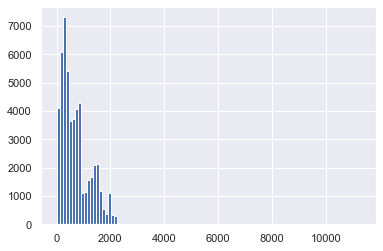

In [144]:
plt.hist(y["time"], bins = 100)

In [147]:
sorted(y["time"])[::-1]

[11295.125,
 6822.083333333333,
 5827.375,
 5745.791666666667,
 4669.916666666667,
 3602.708333333333,
 3408.6666666666665,
 3393.583333333333,
 3356.375,
 3338.2916666666665,
 3336.0,
 3272.833333333333,
 3251.458333333333,
 3220.125,
 3211.2916666666665,
 3198.2916666666665,
 3188.333333333333,
 3185.0416666666665,
 3169.333333333333,
 3117.625,
 3086.625,
 3035.25,
 2998.25,
 2977.958333333333,
 2912.0416666666665,
 2910.708333333333,
 2910.125,
 2865.1666666666665,
 2854.2916666666665,
 2845.4166666666665,
 2764.0,
 2721.2916666666665,
 2661.583333333333,
 2543.0,
 2489.625,
 2483.9166666666665,
 2431.208333333333,
 2380.083333333333,
 2369.833333333333,
 2364.083333333333,
 2338.375,
 2282.083333333333,
 2248.708333333333,
 2234.875,
 2234.7916666666665,
 2234.75,
 2234.5,
 2234.25,
 2234.25,
 2234.208333333333,
 2234.1666666666665,
 2234.125,
 2234.0,
 2233.9166666666665,
 2233.9166666666665,
 2233.875,
 2233.875,
 2233.833333333333,
 2233.833333333333,
 2233.833333333333,
 2233.

In [199]:
hard_disks[hard_disks["time"] > 10000]

,pid,cens,time,num_temp,fac_type,index,Hard Disk Model,Disk Family,Form Factor,Capacity,...,Rotational Speed,Rotation Time,Average Rotational Latency,Drive Ready Time (typical),Average Seek Time,Track To Track Seek Time,Full Stroke Seek Time,Acoustic (Idle),Acoustic (Min performance and volume),Acoustic (Max performance and volume)


In [18]:
hard_disks = pd.read_csv("./hard_disk.csv")
hard_disks = hard_disks.rename({'event': cnt.CENS_NAME, 'time': cnt.TIME_NAME}, axis=1)

ll = BaseFastSurviveModel()
ll.fit(hard_disks)

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_18968\1862964119.py:1: DtypeWarning: Columns (30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  hard_disks = pd.read_csv("./hard_disk.csv")


In [20]:
bins = cnt.get_bins(hard_disks[cnt.TIME_NAME].to_numpy(), hard_disks[cnt.CENS_NAME].to_numpy())

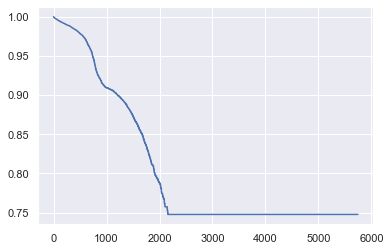

In [21]:
sf = ll.predict_survival_at_times(bins=bins)
plt.step(bins, sf)

In [190]:
cr = CRAID(depth=3, min_samples_leaf=1000, leaf_model="base_fast")
cr.fit(X, y)

In [191]:
sf = cr.predict_at_times(X, bins=bins, mode="surv")

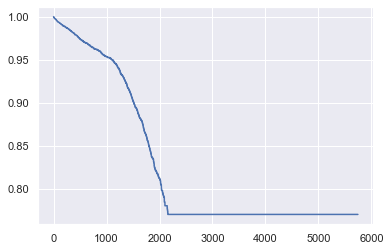

In [197]:
plt.step(bins, sf[-1])

In [198]:
y[-1]

(False, 1385.70833333)

(array([3.0262e+04, 1.3789e+04, 7.4190e+03, 5.5400e+02, 2.5000e+01,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([2.77777778e-03, 1.13726389e+01, 2.27425000e+01, 3.41123611e+01,
        4.54822222e+01, 5.68520833e+01, 6.82219444e+01, 7.95918056e+01,
        9.09616667e+01, 1.02331528e+02, 1.13701389e+02]),
 <BarContainer object of 10 artists>)

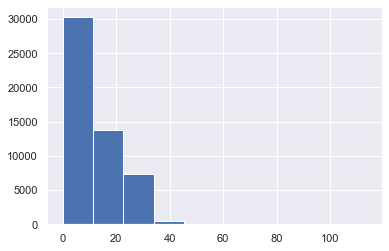

In [235]:
plt.hist(hard_disks["time"]/60)

In [67]:
hard_disks = pd.read_csv("./hdfail.csv")

In [102]:
cols = hard_disks.corr().columns

In [74]:
hard_disks.corr().loc[:,["time", "event"]].sort_values("time")

,time,event
Buffer-Host Max. Rate,-0.746967,-0.047237
Buffer Size,-0.713082,0.014350
Acoustic (Min performance and volume),-0.619171,-0.206217
Acoustic (Idle),-0.582857,-0.204372
Rotation Time,-0.561885,-0.196474
Average Rotational Latency,-0.561123,-0.196318
Acoustic (Max performance and volume),-0.521958,-0.207709
Power Required (Seek),-0.391018,-0.059326
Power Required (Idle),-0.367457,-0.023698
Average Seek Time,-0.279815,-0.172247


<AxesSubplot:>

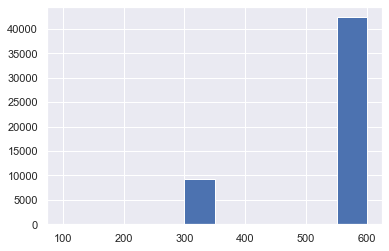

In [95]:
hard_disks["Buffer-Host Max. Rate"].hist()

<AxesSubplot:>

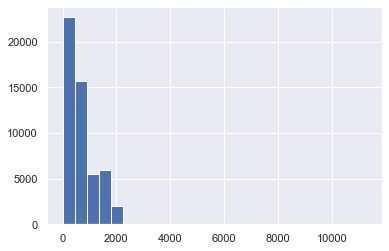

In [80]:
hard_disks["time"].hist(bins=25)

In [88]:
np.log(1 + hard_disks["time"]).min()

0.15415067982725816

In [99]:
from scipy import stats 
sample1 = stats.laplace.rvs(size=105, random_state=100)
sample2 = stats.laplace.rvs(size=95, random_state=100)
stats.kstest(sample1, sample2)

KstestResult(statistic=0.03759398496240601, pvalue=0.999995286892717)

In [116]:
def normal(x):
    return x / np.linalg.norm(x)

hard_disks[cols].apply(lambda x: stats.kstest(normal(x), normal(hard_disks["time"]))).to_dict()

{'pid': {0: 0.14729056428874898, 1: 0.0},
 'event': {0: 0.9446332702483489, 1: 0.0},
 'time': {0: 0.0, 1: 1.0},
 'num_temp': {0: 0.5327913174462168, 1: 0.0},
 'index': {0: 0.8649337607662895, 1: 0.0},
 'Hard Disk Model': {0: 0.2564790853964698, 1: 0.0},
 'Disk Family': {0: 0.23384573790120117, 1: 0.0},
 'Form Factor': {0: 0.7094357112510139, 1: 0.0},
 'Capacity': {0: 0.9185044996330771, 1: 0.0},
 'Number Of Disks': {0: 1.0, 1: 0.0},
 'Number Of Heads': {0: 1.0, 1: 0.0},
 'Disk Interface': {0: 0.8179483218106678, 1: 0.0},
 'Buffer-Host Max. Rate': {0: 1.0, 1: 0.0},
 'Buffer Size': {0: 0.4515661812985207, 1: 0.0},
 'Width': {0: 0.7090881001120081, 1: 0.0},
 'Depth': {0: 0.7047815843343247, 1: 0.0},
 'Height': {0: 0.7017689544629407, 1: 0.0},
 'Weight': {0: 1.0, 1: 0.0},
 'Required Power For Spinup': {0: 1.0, 1: 0.0},
 'Power Required (Seek)': {0: 1.0, 1: 0.0},
 'Power Required (Idle)': {0: 1.0, 1: 0.0},
 'Power Required (Standby)': {0: 1.0, 1: 0.0},
 'Manufacturer': {0: 0.306708894982812

In [115]:
np.linalg.norm(hard_disks["time"].to_numpy())

198230.47634914608

<AxesSubplot:>

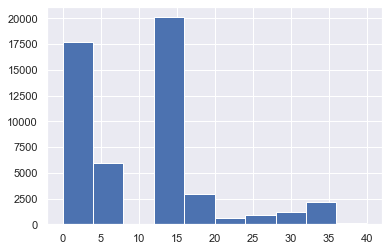

In [118]:
hard_disks['Disk Family'].hist()

In [171]:
X, y, features, categ, sch_nan = load_all_hdfail_dataset()

In [172]:
aftWei = AFTLogLogisticAFTFitter()
X_ = X.copy()
X_[cnt.TIME_NAME] = y[cnt.TIME_NAME]
X_[cnt.CENS_NAME] = y[cnt.CENS_NAME]
aftWei.fit(X_)

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.LogLogisticAFTFitter: fitted with 51782 total observations, 48915 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.5
   number of observations = 51782
number of events observed = 2867
           log-likelihood = -30399.11
         time fit was run = 2022-12-08 14:38:25 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                     
alpha_ Acoustic (Idle)                         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Acoustic (Max performance and volume)   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Acoustic (Min performance and volume)  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Average Rotational Latency              0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Average Seek Time                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer Size                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Buffer-Host Max. Rate                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Capacity                               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Depth                                   0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
       Disk Family                            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Disk Interface                         -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
       Drive Ready Time (typical)             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Form Factor                             0.11       1.11       0.09            -0.07             0.28                 0.94                 1.32
       Full Stroke Seek Time                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Hard Disk Model                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Height                                 -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Manufacturer                           -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Disks                        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Number Of Heads                        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Idle)                  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       Power Required (Seek)                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
       Power Required (Standby)               -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
       Required Power For Spin

None


In [173]:
bins = cnt.get_bins(X_[cnt.TIME_NAME].to_numpy(), X_[cnt.CENS_NAME].to_numpy())

aftWei.predict_survival_at_times(X.iloc[[0], ], bins)

array([[1.        , 0.9999306 , 0.99986121, ..., 0.71501762, 0.71498214,
        0.71494666]])

In [174]:
aftWei.predict_survival_at_times(X.iloc[[1], ], bins)

array([[1.        , 0.99993062, 0.99986124, ..., 0.71506102, 0.71502555,
        0.71499007]])

In [180]:
aftWei.model.median_survival_time_

14336.392161116366

<AxesSubplot:>

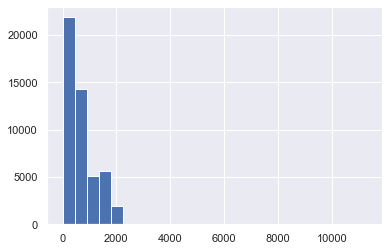

In [175]:
X_[X_[cnt.CENS_NAME] == 0][cnt.TIME_NAME].hist(bins=25)

<AxesSubplot:>

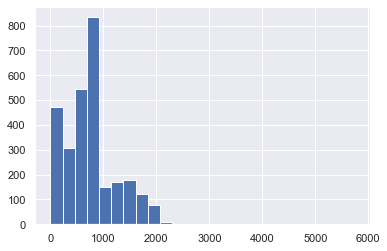

In [176]:
X_[X_[cnt.CENS_NAME] == 1][cnt.TIME_NAME].hist(bins=25)

In [165]:
np.exp(-1 * (bins ** 12454.76))

# X_[np.exp(-1 * (X_[cnt.TIME_NAME] ** 5627.14)) == 1]

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_19532\3669584065.py:1: RuntimeWarning: overflow encountered in power
  np.exp(-1 * (bins ** 12454.76))


array([1.        , 0.36787944, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [155]:
X_["Capacity"].value_counts()

4.0       28347
3.0       12541
2.0        5265
1500.0     3104
6.0         955
1.0         699
500.0       255
160.0       251
320.0       146
80.0        129
250.0        90
Name: Capacity, dtype: int64

In [177]:
X_[X_[cnt.CENS_NAME] == 0][cnt.TIME_NAME].value_counts()

52.250000      299
419.208333     297
293.333333     253
286.375000     234
419.250000     226
              ... 
1705.291667      1
1662.583333      1
1840.000000      1
1823.041667      1
1385.708333      1
Name: time, Length: 7966, dtype: int64